# Gaussian Process Regression

This demo shows how to use the GaussianProcessRegressor class to calculate the efficiency of three-jet events with MET < 50 GeV. Derivatives are used to 
enhance the regression.

The following nuisance parameters are considered:
- $\nu_{J1in}$: Jet energy scale of the leading jet, $J_1$, when |$\eta_1$| < 1.
- $\nu_{J1out}$: Jet energy scale of the leading jet, $J_1$, when |$\eta_1$| >= 1.
- $\nu_{J23in}$: Jet energy scale of the two softer jets, $J_2$ and $J_3$, when |average($\eta_2$, $\eta_3$)| < 1.
- $\nu_{J23out}$: Jet energy scale of the two softer jets, $J_2$ and $J_3$, when |average($\eta_2$, $\eta_3$)| >= 1.

In [1]:
# Imports
import gpder
from gpder.gaussian_process import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel, DerivativeKernel

import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, Arrow, FancyArrow
%matplotlib inline  

from multiprocessing import Pool, cpu_count

In [2]:
from utils import download_dataset, load_dataset

# Downloading the dataset from zenodo. 
# By default, the h5df file is saved in the current directory.
download_dataset()
threeM = load_dataset()

# The dataset consists of 30000 events, each with three jets. 
# For each jet, the three-momenta (pT, eta, phi) are saved in descending pT-order.
print("Shape of the dataset:", threeM.shape)

Shape of the dataset: (30000, 3, 3)


Title: Estimation of Unfactorizable Systematic Uncertainties
Keywords: 
Publication date: 2024-04-14
DOI: 10.5281/zenodo.10971439
Total size: 1.0 MB

Link: https://zenodo.org/api/records/10971439/files/three_jets_30k.h5/content   size: 1.0 MB
three_jets_30k.h5 is already downloaded correctly.
All files have been downloaded.


In [4]:
# Function that calculates the efficiency with respect to the two nuisance
# See hep_functions.py for more details
from hep_functions import efficiency
def efficiency_events(X, three=threeM):
    # Simplifying the input
    return efficiency(X, threeM)


# And the function that calculates the gradient of the efficiency
# To improve numerical stability, we smooth out the gradients by setting the
# parameter a=1/10
from hep_functions import der_efficiency
def der_efficiency_events_sigmoid10(X, three=threeM):
    # Simplifying the input
    return der_efficiency(X, threeM, a=1/10)

In [5]:
# -- Testing dataset ------------------------------------------------------- #
res_test = 25
X_lower, X_upper = 0.5, 1.5
lin = np.linspace(X_lower, X_upper, res_test)
nu_J1_in_test, nu_J1_out_test, nu_J23_in_test, nu_J23_out_test = np.meshgrid(
    lin, lin, lin, lin
)
X_test = np.array(
    [
        nu_J1_in_test.flatten(),
        nu_J1_out_test.flatten(),
        nu_J23_in_test.flatten(),
        nu_J23_out_test.flatten(),
    ]
).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test)
# -------------------------------------------------------------------------- #

In [6]:
def generate_training_grid(res):
    cent_val = (X_lower + X_upper) / 2.0
    st = (cent_val - X_lower) / 2.0
    X_coords = np.linspace(np.repeat(X_lower, 4) + st, np.repeat(X_upper, 4) - st, res)
    n = len(X_coords)
    X_grid = np.ones((n * 4, 4)) * cent_val
    for i in range(4):
        X_grid[i * n : (i + 1) * n, i] = X_coords[:, i]
    X_grid_set = set()
    for x in X_grid:
        tupl = tuple(x)
        if tupl not in X_grid_set:
            X_grid_set.add(tupl)
    return np.array(list(X_grid_set))


# -- Trainning dataset ----------------------------------------------------- #
X_train = generate_training_grid(res=3)
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train).reshape(
    -1,
)
dX_train = X_train
dy_train = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_train)
dy_train = np.array(dy_train).reshape(-1, 4)
# -------------------------------------------------------------------------- #

In [7]:
# -- Fitting the model and hyperparameter optimization --------------------- #
kernel = DerivativeKernel(amplitude=0.1, length_scale=0.25, noise_level=1e-3, noise_level_der=1e-1)
gp = GaussianProcessRegressor(
    kernel=kernel, optimizer=None, random_state=42
)
gp.fit(X_train, y_train, dX_train, dy_train)
print("\nKernel: ")
print(gp.kernel)
# -------------------------------------------------------------------------- #

# -- Prediction and eval --------------------------------------------------- #
# predicting such a large dataset can occupy a lot of memory
# so we predict in batches
batch_size = 128
n_batches = len(X_test) // batch_size + 1
y_pred_mean = np.zeros(len(X_test))
y_pred_std = np.zeros(len(X_test))
cov_trace = 0.0
for i in range(n_batches):
    start = i * batch_size
    end = min((i + 1) * batch_size, len(X_test))
    mu, std = gp.predict(X_test[start:end], return_std=True)
    y_pred_mean[start:end] = mu.ravel()
    y_pred_std[start:end] = std.ravel()

print("\nEvaluation ")
mse = np.sum((y_test - y_pred_mean.ravel()) ** 2) / len(y_test)
print("MSE: ", mse)
print("Total variance: ", np.sum(y_pred_std**2))
# -------------------------------------------------------------------------- #


Kernel: 
0.1**2 * DerivativeRBF(length_scale=0.25) + WhiteKernel(noise_level=0.001) + WhiteKernel_der(noise_level=0.1)

Evaluation 
MSE:  0.0642891857604422
Total variance:  2599.507315466332


Visualizing the efficiency as a function of the four nuisance parameters can be challenging.  
Instead, we plot the efficiency as we vary two parameters while setting the other two to have a value of 0.5.

In [8]:
from utils import plot_regression

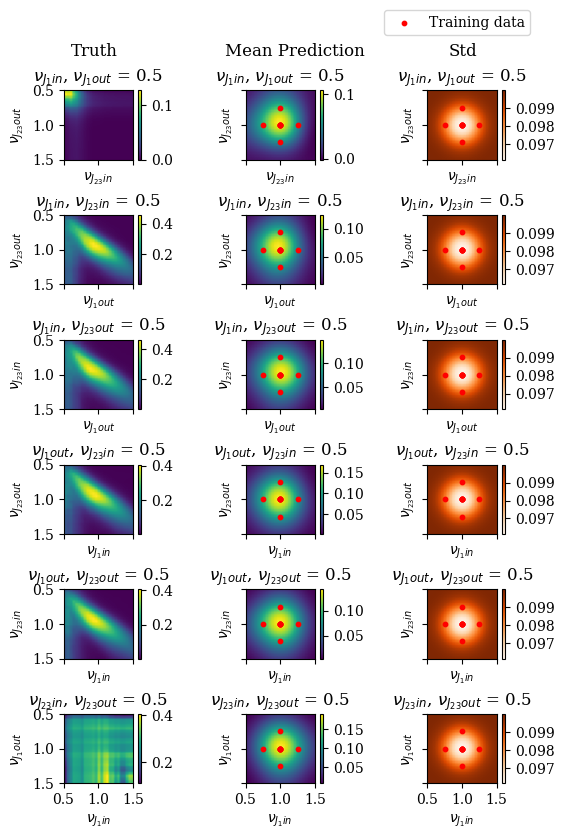

In [9]:
plot_regression(gp, X_test, y_test)